In [38]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

from hnn_core.batch_simulate import BatchSimulate
from hnn_core import jones_2009_model, pick_connection, calcium_model, read_params
from hnn_core.network_models import add_erp_drives_to_jones_model
from sbi.inference import NPE
from sbi import utils

import pandas as pd
import seaborn as sns
import torch
import os

# The number of cores may need modifying depending on your current machine.
n_jobs = 50

In [39]:
def set_params(param_values, net):
    """
    Set parameters for the network drives.

    Parameters
    ----------
    param_values : dict
        Dictionary of parameter values.
    net : instance of Network
        Network to be updated
    """

    # Dendritic Km
    for sec_name, sec in net.cell_types['L5_pyramidal']['cell_object'].sections.items():
        if sec_name != 'soma':
            sec.mechs['km']['gbar_km'] *= (10 ** param_values['km_scale'])

    # Inhibitory gain sweep
    conn_indices = pick_connection(net, target_gids=['L2_basket', 'L5_basket'], receptor=['gabaa'])
    for conn_idx in conn_indices:
        net.connectivity[conn_idx]['nc_dict']['A_weight'] *= 10 ** param_values['inh_gain_scale']

    # Feedforward gain sweep
    conn_indices = pick_connection(net, src_gids=['evprox1', 'evprox2'])
    for conn_idx in conn_indices:
        net.connectivity[conn_idx]['nc_dict']['A_weight'] *= 10 ** param_values['ff_gain_scale']

In [40]:
save_path = '/oscar/data/sjones/ntolley/hnn_jove'


rng = np.random.default_rng(seed=123)

min_val, max_val = -1, 1
num_sims = 10000


theta_train_dict = {
    'ff_gain_scale': rng.uniform(min_val, max_val, num_sims),
    'km_scale': rng.uniform(min_val, max_val, num_sims),
    'inh_gain_scale': rng.uniform(min_val, max_val, num_sims),
}

theta_cond_dict = {
    'ff_gain_scale':  [0, 1, 0, 0],
    'km_scale':       [0, 0, 1, 0],
    'inh_gain_scale': [0, 0, 0, 1],
}

# Initialize the network model and run the batch simulation.
l_contra_params = read_params('../data/L_Contra.param')
net_base = calcium_model(params=l_contra_params, add_drives_from_params=True)

# net = jones_2009_model()
# add_erp_drives_to_jones_model(net)




In [41]:
# Class to handle running and saving large trainng batches
batch_simulation = BatchSimulate(net=net,
                                 set_params=set_params,
                                 save_outputs=True,
                                 save_dpl=True,
                                 tstop=170,
                                 dt=0.5,
                                 save_folder=save_path,
                                 overwrite=True,
                                 clear_cache=True)

_ = batch_simulation.run(theta_train_dict,
                         n_jobs=n_jobs,
                         combinations=False,
                         backend='loky')

    
# Class for quickly generating conditioning observations with no saving
batch_simulation_cond = BatchSimulate(net=net,
                                      set_params=set_params,
                                      tstop=170,
                                      dt=0.5,)

cond_results = batch_simulation_cond.run(theta_cond_dict,
                                          n_jobs=n_jobs,
                                          combinations=False,
                                          backend='loky')

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graph

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building th

In [43]:
# Load batch simulations used for SBI training
dpl_list, theta_train = list(), list()
for fname in os.listdir(save_path):
    res = np.load(f'{save_path}/{fname}', allow_pickle=True)
    for dpl in res['dpl']:
        dpl_list.append(dpl[0].copy().smooth(30).data['agg'])

    for param_dict in res['param_values']:
        theta_train.append(np.array(list(param_dict.values())))

dpl_list = np.array(dpl_list)
theta_train = np.array(theta_train)

# Fit PCA to training simulations
pca = PCA(n_components=10)
x_train = pca.fit_transform(dpl_list)
dpl_transform = pca.inverse_transform(x_train)

# Load conditioning simulations and project onto PCA components
cond_dpl = [dpl_data['dpl'][0].copy().smooth(30).data['agg'] for dpl_data in cond_results['simulated_data'][0]]
cond_dpl = np.array(cond_dpl)
x_cond = pca.transform(cond_dpl)


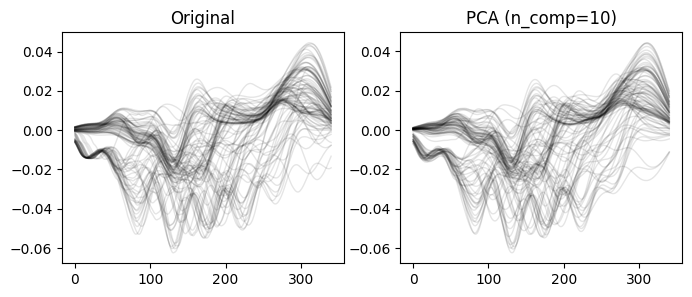

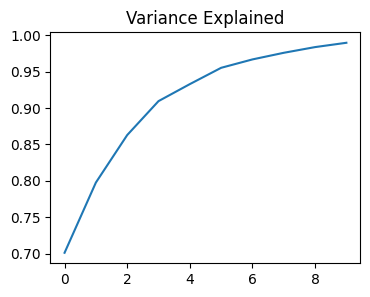

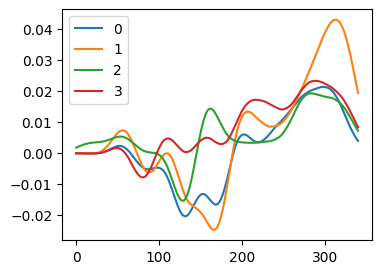

In [44]:
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
_ = plt.plot(dpl_list[:100, :].T, color='k', alpha=0.1, linewidth=1)
plt.title('Original')
plt.subplot(1,2,2)
_ = plt.plot(dpl_transform[:100, :].T, color='k', alpha=0.1, linewidth=1)
plt.title('PCA (n_comp=10)')

plt.figure(figsize=(4,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Variance Explained')


plt.figure(figsize=(4,3))
plt.plot(cond_dpl.T, label=[0, 1, 2, 3])
plt.legend()

In [45]:
prior_min = [min_val] * 3
prior_max = [max_val] * 3
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

# Create inference object. Here, NPE is used.
inference = NPE(prior=prior)
inference = inference.append_simulations(torch.tensor(theta_train).float(), torch.tensor(x_train).float())

# train the density estimator and build the posterior
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Training neural network. Epochs trained: 64

KeyboardInterrupt: 

In [15]:
num_samples = 1000
label_names = ['base', 'ff_gain_scale', 'km_scale', 'inh_gain_scale']
sample_list, label_list = list(), list()

for cond_idx in range(x_cond.shape[0]):
    samples = posterior.sample((num_samples,), x=x_cond[cond_idx,:])
    sample_list.append(samples.numpy())

    label_list.extend(np.repeat(label_names[cond_idx], num_samples))

sample_list = np.concatenate(sample_list)

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 90271.92it/s]
Drawing 1000 posterior samples: 1107it [00:00, 62050.23it/s]            
Drawing 1000 posterior samples: 1062it [00:00, 63371.95it/s]            
Drawing 1000 posterior samples: 1064it [00:00, 68873.69it/s]            


In [22]:
# param_labels = ['FF gain ($\\bar{g}$)', 'Km channel ($\\bar{g}$)', 'GABA$\\rightarrow$I cell ($\\bar{g}$)']
param_labels = ['FF gain (a.u.)', 'Km channel (a.u.)', 'GABA$\\rightarrow$I cell (a.u.)']

sample_list = np.array(sample_list)
df = pd.DataFrame(sample_list)
df.columns = param_labels
df['cond'] = label_list
df = df[df['cond'] != 'base']

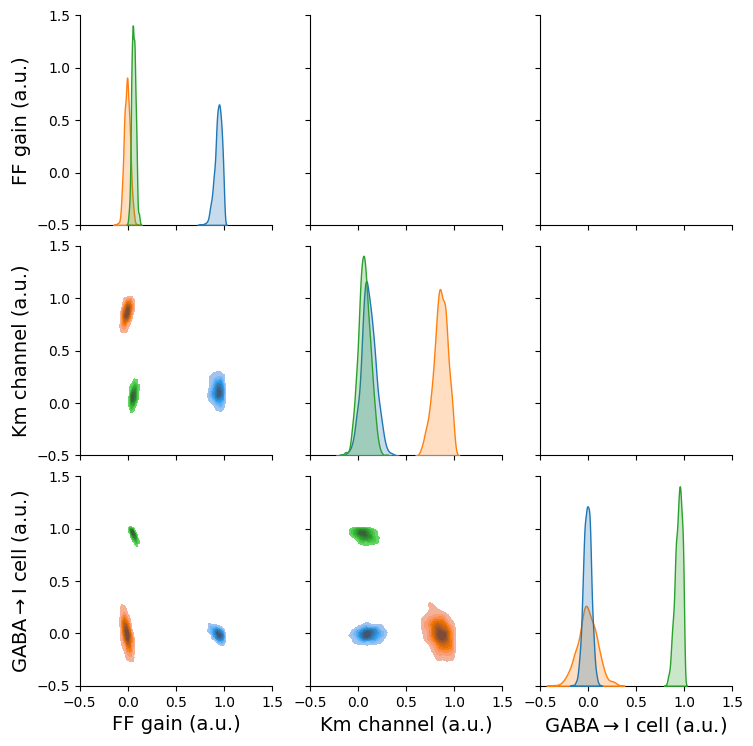

In [24]:
labelsize = 14

color_palette = ['C0', 'C1', 'C2']

g = sns.PairGrid(df, diag_sharey=False, corner=False, hue='cond', palette=color_palette)
g.map_lower(sns.kdeplot, fill=True, common_norm=False)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(3):
    # y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])
    g.axes[idx, idx].set_xlim(-0.5, 1.5)
    g.axes[idx, idx].set_ylim(-0.5, 1.5)

    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[2,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

            
    # g.axes[idx, 0].set_yticks(tick_dict[f'p{idx+4}_tick_pos'])
    # g.axes[3, idx].set_xticks(tick_dict[f'p{idx+4}_tick_pos'])
    # g.axes[idx, 0].set_yticklabels(tick_dict[f'p{idx+4}_tick_labels'], fontsize=ticksize, rotation=0)
    # g.axes[3, idx].set_xticklabels(tick_dict[f'p{idx+4}_tick_labels'], fontsize=ticksize, rotation=0)

plt.savefig('../figures/drug_moa_sbi_posterior.svg')